In [1]:
import os
import numpy as np
from tqdm import tqdm
import sklearn.preprocessing
import pandas as pd
import warnings
from sklearn.decomposition import PCA
from copy import deepcopy
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
SC_ids = set() #All sem classes
path = "SampleCorpus_new/SemanticHierarchy_ID.txt"
with open(path) as f:
    for line in f.readlines():
        sc_id, parrent_id, name = line.split()
        if name != "Name":
            SC_ids.add(int(sc_id))
            if parrent_id != "NULL":
                SC_ids.add(int(parrent_id))

In [12]:
SC_parrents = dict() #sc -> parrent sc
SC_name_to_id = dict() #sc -> name
path = "SampleCorpus_new/SemanticHierarchy_ID.txt"
with open(path) as f:
    for line in f.readlines():
        sc_id, parrent_sc, sc_name = line.split()
        if sc_name != "Name":
            SC_name_to_id[sc_name] = int(sc_id)
            if parrent_sc != "NULL":
                SC_parrents[int(sc_id)] = int(parrent_sc)
                
LC_to_SC = dict() #lc -> parrent 
path = "SampleCorpus_new/SemanticHierarchy_lexical_vs_semantic.txt"
with open(path, encoding="utf8") as f:
    i = 0
#     lc = set()
#     sc = set()
    for line in f.readlines():
        lc_id, lc_name, sc_id, sc_name = line.split("\t")
#         lc.add(lc_id)
#         sc.add(sc_id)
#         if lc_id in sc:
#             print("WDSFF", lc_id)
#         if sc_id in lc:
#             print("!!!!!!", sc_id)
        if i > 0:
            LC_to_SC[int(lc_id)] = int(sc_id)
        i += 1

Для загрузки предобученных эмбеддингов семантических классов.

In [13]:
def load_embeddings(filename):
    emb = dict()
    with open(filename, encoding="utf-8") as f:
        f.readline()
        N, dim = 93892, 200
        for i in range(N):
            line = f.readline().split()
            try: 
                emb[int(line[0])] = np.array(list(map(float, line[1:])))
            except ValueError: #some problems with 80578 line
                emb[int(line[0][1:])] = np.array(list(map(float, line[1:])))
    return emb

In [14]:
sem_class = load_embeddings("SampleCorpus_new/embeddings.txt")

In [15]:
def get_sc_emb(sc_id, sc_embeddings):
    if sc_id in sc_embeddings:
        return sc_embeddings[sc_id]
    while sc_id not in sc_embeddings:
        if sc_id in LC_to_SC:
            sc_id = LC_to_SC[sc_id]
        elif sc_id in SC_parrents:
            sc_id = SC_parrents[sc_id]
        else:
            return np.zeros(200)
    return sc_embeddings[sc_id]

In [30]:
# path_mentions = "SampleCorpus_new" + os.sep + "Mentions"
# path_chains = "SampleCorpus_new" + os.sep + "Chains"
# path_morph = "SampleCorpus_new" + os.sep + "Morph"
# path_sem_synt = "SampleCorpus_new" + os.sep + "Sem_synt"
# path_texts = "SampleCorpus_new" + os.sep + "Texts"

path_mentions = "Corpora" + os.sep + "Mentions"
path_chains = "Corpora" + os.sep + "Chains"
path_morph = "Corpora" + os.sep + "Morph"
path_sem_synt = "Corpora" + os.sep + "Sem_synt"
path_texts = "Corpora" + os.sep + "Texts"


def invert_dict(d):
    return dict([ (v, k) for k, v in d.items( ) ])


post_ = {
    "NOUN": 0, #имя существительноe
    "ADJF": 1, #имя прилагательное (полное)
    "ADJS": 2, #имя прилагательное (краткое)
    "COMP": 3, #компаратив
    "VERB": 4, #глагол (личная форма)
    "INFN": 5, #глагол (инфинитив)
    "PRTF": 6, #причастие (полное)
    "PRTS": 7, #причастие (краткое)
    "GRND": 8, #деепричастие
    "NUMR": 9, #числительное
    "ADVB": 10, #наречие
    "NPRO": 11, #местоимение-существительное
    "PRED": 12, #предикатив
    "PREP": 13, #предлог
    "CONJ": 14, #союз
    "PRCL": 15, #частица
    "INTJ": 16, #междометие
    "PNCT": 17, #знак препинания
    "ROMN": 18  #римские цифры
}
post_invert = invert_dict(post_)

anim_ = {
    "anim": 1, #одушевлённое
    "inan": 0 #неодушевлённое
}

gend_ = {
    "masc": 0, #мужской
    "femn": 1, #женский
    "neut": 2, #средний
    "ms-f": 3  #общий
}

num_ = {
    "sing": 1, #единственное число
    "plur": 0  #множественное число
}

def get_one_hot_encoded_vector(i, N):
    if len(i) == 0:
        return np.zeros(N, dtype=int)
    b = np.zeros(N)
    for ind in i:
        b[ind] += 1
    return b / np.sum(b)

In [35]:
def merge_all_information(book_id, add_text=False, get_features=False, get_data=True):
    
    #открываю все нужные файлы по номеру книги
    mentions_file = path_mentions + os.sep + book_id
    chains_file = path_chains + os.sep + book_id
    morph_file = path_morph + os.sep + book_id
    sem_file = path_sem_synt + os.sep + book_id
    book_file = path_texts + os.sep + book_id
        
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        #Mention Id→Mention Offset→Mention Length
        dataset_mentions = np.loadtxt(mentions_file, dtype=int, delimiter="\t")
        #Mention Id→Mention Offset→Mention Length→Chain Id
        dataset_chains = np.loadtxt(chains_file, dtype=int, delimiter="\t")
        #Token Id→Offset→Length→Token→Lemma→Morphology Tags
        dataset_morph = np.loadtxt(morph_file, dtype=str, delimiter="\t", encoding="utf-8")
        #Offset→Token→Parent Offset→Semantic Class Id→SyntParadigm Id
        dataset_sem_synt = np.loadtxt(sem_file, dtype=str, delimiter="\t", encoding="utf-8")
        book_content = open(book_file, "r", encoding="utf-16").read()
    
    if len(dataset_mentions) == 0 or len(dataset_chains) == 0 \
        or len(dataset_morph) == 0 or len(dataset_sem_synt) == 0:
        return dict()
    
    book_length = len(book_content)
    #все эмбеддинги по всем упоминаниям (!не по словам)
    content_emb = []
    #все эмбеддинги по всем словам 
    all_embeddings = []
    
    #хотим знать, где начинаются новые предложения
    new_sentense_offsets = [0]
    with open(path_morph + os.sep + book_id) as f:
        is_new = False
        for line in f.readlines():
            if is_new and len(line.split('\t')) >= 2: 
                new_sentense_offsets.append(int(line.split('\t')[1]))
                is_new = False
            if len(line.split('\t')) < 5:
                is_new = True
    #массив для нахождения первого упоминания в предложении
    first_ment_in_sent = new_sentense_offsets[1:]
    first_ment_in_sent.append(book_length)
                
    
    dataset = dict()
    features = []
    #добавим информацию об упоминании
    for ment in dataset_mentions:
        id_ment = ment[0]
        offset = ment[1]
        length = ment[2]
        dataset[id_ment] = [offset, length] # offset, length
        assert len(dataset[id_ment]) == 2, dataset[id_ment]
    
    features.append("offset")
    features.append("length")
    
    #добавим информацию о номере цепочки    
    #посчитаем количество цепочек
    chain_ids = set()
    ment_in_chains = set()
    is_anaphoric = False
    chain_num = 0
    for ment in dataset_chains:
        chain = int(ment[3])
        id_ment = int(ment[0])
        offset = int(ment[1])
        length = int(ment[2])
        assert id_ment not in ment_in_chains, ment
        ment_in_chains.add(id_ment)
        is_anaphoric = (chain in chain_ids)
        if not is_anaphoric:
            chain_ids.add(chain)
            chain_num += 1
            dataset[id_ment].append(0) #не анафорическое
        else:
            dataset[id_ment].append(1) #анафорическое
        assert len(dataset[id_ment]) == 3, dataset[id_ment]
    
    #если упоминание не состояло ни в одной цепочке
    #в качестве признака анафоричности запишем 1
    for ment in dataset.keys():
        #print(ment)
        if len(dataset[ment]) == 2:
            dataset[ment].append(0) #не анафорическое
        assert len(dataset[ment]) == 3, dataset[ment]
        dataset[ment].append(book_id)
    
    features.append("is anaforic")
    features.append("book id")
    
    
    compreno_offsets = []
    sem_synt_info = dict()
    
    parents = dict()
    for token in dataset_sem_synt:
        offset = token[0]
        try:
            offset = int(offset)
        except ValueError:
            offset = token[0][1:]
            offset = int(offset)
        compreno_offsets.append(offset)
        length = len(token[1])
        parent_offset = token[2]
        lc = int(token[3])
        synt_par = int(token[4])
        if (parent_offset == "NA"):
            parent_offset = -1
        parent_offset = int(parent_offset)
        parents[offset] = parent_offset
        try:
            sem_synt_info[offset] = [length, parent_offset, LC_to_SC[lc], synt_par]
        except KeyError:
            sem_synt_info[offset] = [length, parent_offset, lc, synt_par] 
        all_embeddings.append(get_sc_emb(sem_synt_info[offset][2], sem_class))
            #print(offset)
        
    offsets = [] #список всех оффсетов для всех токенов по версии морфологии
    
    lemms = set() #добавим в качестве признака встречалась ли лемма в тексте ранее
    morph_info = dict()
    for token_info in dataset_morph:
        offset = token_info[1]
        try:
            offset = int(offset)
        except ValueError:
            #print(token_info)
            offset = token_info[1][1:]
            offset = int(offset)
            
        offsets.append(offset)
        length = token_info[2]
        token = token_info[3]
        lemma = token_info[4]
        is_first = not(lemma in lemms)
        lemms.add(lemma)
        #morph_info[offset] = [length]  # добавили длину
        morph_info[offset] = [int(is_first)]  # первый раз встречается лемма или нет
        tags = token_info[5]
        set_tags = set(tags.split()[0].split(",")) #получили множество всех тегов
        if len(tags.split()) > 1:
            set_tags |= set(tags.split()[1].split(","))
        morph_info[offset].append(set_tags)
        morph_info[offset].append(token)
        
    #offsets, parents
    def find_head(offset, length):
        token_ind = offsets.index(offset)
        cur_offset = offset
        token_parents = []
        while offsets[token_ind] < offset + length: 
            if offsets[token_ind] in parents and parents[offsets[token_ind]] > offset and \
                                            parents[offsets[token_ind]] < offset + length:
                token_parents.append(parents[offsets[token_ind]])
            token_ind += 1
            if token_ind == len(offsets):
                break
        if len(token_parents) == 0:
            return offset
        return token_parents[0]
        
        
    already = False
    for id_ment in dataset:
        length = dataset[id_ment][1]
        offset = dataset[id_ment][0]
        
        token_ind = offsets.index(offset)
        tokens_in_ment = 0
        embeddings = [] #для семантических классов всего упоминания
        pos_tags = []
        anim = False 
        is_first = False
        sing = False
        cur_offset = offset
        while cur_offset < offset + length: 
            tokens_in_ment += 1
            token_ind += 1
            #посчитаем семантико-синтаксические признаки
            if cur_offset in sem_synt_info:
                sem_class_id = sem_synt_info[cur_offset][2]
                embeddings.append(get_sc_emb(sem_class_id, sem_class))
            #обработаем морфологические признаки
            if cur_offset in morph_info:

                is_first |= morph_info[cur_offset][0] # один из токенов встретился в тексте первый раз
                tag_set = morph_info[cur_offset][1]

                post = tag_set & post_.keys()
                pos_tags.extend(list(post))
            
            if (token_ind < len(offsets)):
                cur_offset = offsets[token_ind]
            else:
                break
        
        if add_text:
            dataset[id_ment].append(book_content[offset:offset+length])
            if not already:
                features.append("text")
            
        # нормализованное расстояние до начала текста
        head_offset = offset
        if tokens_in_ment > 1:
            head_offset = offsets[np.searchsorted(offsets, find_head(offset, length), side='right') - 1]
        dataset[id_ment].append(head_offset/book_length)
        if not already:
            features.append("head offset")
        
        dataset[id_ment].append(int(is_first))
        if not already:
            features.append("is first")
            
        head_tag_set = morph_info[head_offset][1]
        if "anim" in head_tag_set:
            anim = True
        dataset[id_ment].append(int(anim))
        if not already:
            features.append("anim")
            
        if "sing" in head_tag_set:
            sing = True
        dataset[id_ment].append(int(sing))
        if not already:
            features.append("is sing")
        
        dataset[id_ment].append(tokens_in_ment) #количество токенов в упоминании
        if not already:
            features.append("number of tokens")
        
        # Найдём расстояние для ближайшего по эмбеддингу слова
        min_dist = 1000
        closest = 0
        token_ind = np.searchsorted(compreno_offsets, offset, side='left')
        if head_offset in sem_synt_info:
            sem_class_id = sem_synt_info[head_offset][2]
            ment_emb = get_sc_emb(sem_class_id, sem_class)
        else:
            ment_emb = np.mean(np.array(embeddings), axis=0)
        content_emb.append(ment_emb) # эмбеддинг главного слова, если это возможно, иначе - средний по всем
        for i in range(token_ind):
            cur_sem_class_id = sem_synt_info[compreno_offsets[i]][2]
            cur_emb = get_sc_emb(cur_sem_class_id, sem_class)
            if cosine_similarity(cur_emb.reshape(1, -1), ment_emb.reshape(1, -1)) < min_dist:
                min_dist = cosine_similarity(cur_emb.reshape(1, -1), ment_emb.reshape(1, -1))
                closest = compreno_offsets[i]
        
        #расстояние до начала предложения
        dataset[id_ment].append((offset - closest) / book_length) 
        if not already:
            features.append("offset distance to the closest token")
            
        dataset[id_ment].append(0 if min_dist == 1000 else min_dist[0][0])
        if not already:
            features.append("distance to closest embedding")
        
        # Найдём эмбеддинг левого контекста
        left_context_start = max(0, token_ind - 5)
        mean_emb_left = np.zeros(200)
        for i in range(left_context_start, token_ind):
            mean_emb_left += all_embeddings[i]
        #добавим расстояние до ment_emb
        if token_ind == left_context_start:
            dataset[id_ment].append(0)
        else:
            mean_emb_left /= (token_ind - left_context_start)
            dataset[id_ment].append(cosine_similarity(mean_emb_left.reshape(1, -1), ment_emb.reshape(1, -1)))
        
        
        # Найдём эмбеддинг правого контекста
        right_context_end = min(token_ind + 6, len(all_embeddings))
        mean_emb_right = np.zeros(200)
        for i in range(token_ind + 1, right_context_end):
            mean_emb_right += all_embeddings[i]
        #добавим расстояние до ment_emb
        if token_ind == right_context_end:
            dataset[id_ment].append(0)
        else:
            mean_emb_right /= (token_ind - right_context_end)
            dataset[id_ment].append(cosine_similarity(mean_emb_right.reshape(1, -1), ment_emb.reshape(1, -1)))
        
        if not already:
            features.append("distance to left context")
            features.append("distance to right context")
            
        # Расстояние до предыдущего упоминания
        if id_ment == 1:
            dataset[id_ment].append(0)
            dataset[id_ment].append(0)
        else:
            dataset[id_ment].append((dataset[id_ment-1][0] - dataset[id_ment][0])/book_length)
            dataset[id_ment].append(cosine_similarity(ment_emb.reshape(1, -1), content_emb[-2].reshape(1,-1)))
        
        if not already:
            features.append("distance to prev mention")
            features.append("emb distance to prev mention")
            
        # Расстояние до начала предложения (нормализованное)
        sent_index = np.searchsorted(new_sentense_offsets, offset, side='right') - 1
        sent_start = new_sentense_offsets[sent_index]
        dataset[id_ment].append((offset - sent_start)/book_length) #расстояние до начала предложения
        if not already:
            features.append("distance to sentence start")
            
        #расстояние до среднего эмбеддинга по предыдущим упоминаниям
        dataset[id_ment].append(cosine_similarity(ment_emb.reshape(1, -1), np.mean(content_emb, axis=0).reshape(1, -1)))
        if not already:
            features.append("distance to mean mention embedds")
        
        
        
        #расстояние до ближайшего эмбеддинга по предыдущим упоминаниям
        min_dist = 1000
        for emb in content_emb[:-1]:
            if cosine_similarity(emb.reshape(1, -1), ment_emb.reshape(1, -1)) < min_dist:
                min_dist = cosine_similarity(emb.reshape(1, -1), ment_emb.reshape(1, -1))
        dataset[id_ment].append(0 if min_dist==1000 else min_dist[0][0])
        if not already:
            features.append("distance to closest mention embedds")
        
        #добавим признак в качестве вектора с составом по частям речи
        dataset[id_ment].extend(get_one_hot_encoded_vector(list(map(lambda x: post_[x], pos_tags)), len(post_)))
        if not already:
            features.extend([post_invert[i] for i in range(len(post_))])
            
            
            
#         if len(embeddings) > 0:
#             dataset[id_ment].extend(np.mean(np.array(embeddings), axis=0)) #средний эмбеддинг
#             dataset[id_ment].extend(np.min(np.array(embeddings), axis=0)) #минимальный эмбеддинг
#         else:
#             #print(id_ment, dataset[id_ment])
#             dataset[id_ment].extend(np.zeros(200))
#             dataset[id_ment].extend(np.zeros(200))
#         if not already:
#             features.extend(["mean emb["+str(i)+"]" for i in range(200)])
#             features.extend(["min emb["+str(i)+"]" for i in range(200)])
        
        
        already = True
        assert len(features) == len(dataset[id_ment]), len(features) 
        
        
    if get_features and get_data:
        return dataset, features
    if get_features:
        return features
    return dataset

In [47]:
%%time
book_2, index = merge_all_information("book_3655.txt", get_features=True, add_text=True)

ValueError: 464 is not in list

In [44]:
set_2 = pd.DataFrame(data=book_2, index=index, columns=book_2.keys()).T

In [45]:
set_2

,offset,length,is anaforic,book id,text,head offset,is first,anim,is sing,number of tokens,...,NUMR,ADVB,NPRO,PRED,PREP,CONJ,PRCL,INTJ,PNCT,ROMN
1,10,19,0,book_852.txt,писатель Пётр Вайль,0.0224852,1,1,1,3,...,0,0,0,0,0,0,0,0,0,0
2,31,17,1,book_852.txt,Автор «Американы»,0.0366864,1,1,1,4,...,0,0,0,0,0,0,0,0,0.5,0
3,37,11,0,book_852.txt,«Американы»,0.043787,1,0,0,3,...,0,0,0,0,0,0,0,0,0.666667,0
4,158,8,0,book_852.txt,писатель,0.186982,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
5,158,31,1,book_852.txt,писатель и журналист Пётр Вайль,0.2,1,1,1,5,...,0,0,0,0,0,0.2,0,0,0,0
6,169,20,0,book_852.txt,журналист Пётр Вайль,0.211834,1,1,1,3,...,0,0,0,0,0,0,0,0,0,0
7,211,54,1,book_852.txt,"талантливому автору многочисленных книг, стате...",0.265089,1,1,1,8,...,0,0,0,0,0,0.125,0,0,0.125,0
8,231,19,0,book_852.txt,многочисленных книг,0.291124,1,0,0,2,...,0,0,0,0,0,0,0,0,0,0
9,252,6,0,book_852.txt,статей,0.298225,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10,261,4,0,book_852.txt,эссе,0.308876,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [39]:
print("\n".join(index))

offset
length
is anaforic
book id
text
head offset
is first
anim
is sing
number of tokens
offset distance to the closest token
distance to closest embedding
distance to left context
distance to right context
distance to prev mention
emb distance to prev mention
distance to sentence start
distance to mean mention embedds
distance to closest mention embedds
NOUN
ADJF
ADJS
COMP
VERB
INFN
PRTF
PRTS
GRND
NUMR
ADVB
NPRO
PRED
PREP
CONJ
PRCL
INTJ
PNCT
ROMN


In [54]:
dataset

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
1,0,8,0,book_60.txt,Исландия,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,50,18,0,book_60.txt,Парламент Исландии,0.0338524,1,0,1,2,...,0,0,0,0,0,0,0,0,0,0
3,60,8,1,book_60.txt,Исландии,0.0406229,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,107,12,1,book_60.txt,этой страной,0.0758294,1,0,1,2,...,0,0,0,0,0,0,0,0,0,0
5,295,10,0,book_60.txt,«Лента.ру»,0.200406,1,0,1,3,...,0,0,0,0,0,0,0,0,0.666667,0
6,390,6,1,book_60.txt,стране,0.264049,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
7,469,8,0,book_60.txt,площадку,0.317536,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
8,623,8,1,book_60.txt,Исландию,0.421801,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
9,646,24,0,book_60.txt,известный сайт Wikileaks,0.444144,1,0,1,3,...,0,0,0,0,0,0,0,0,0,0
10,816,4,1,book_60.txt,сайт,0.552471,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [55]:
%%time
#reading
files = os.listdir(path_mentions)
dataset = pd.DataFrame(merge_all_information(files[0], add_text=True)).T
for item in tqdm(files[1:]):
    print(item)
    if not item in {"book_3655.txt", "book_3857.txt"}:
        data = pd.DataFrame(merge_all_information(item, add_text=True)).T
        dataset = dataset.append(data)
    #print(len(dataset))





  0%|          | 0/119 [00:00<?, ?it/s]

book_41.txt





  1%|          | 1/119 [00:59<1:56:23, 59.18s/it]

book_1870.txt





  2%|▏         | 2/119 [00:59<58:01, 29.76s/it]  

book_2373.txt





  3%|▎         | 3/119 [01:06<42:47, 22.14s/it]

book_2203.txt





  3%|▎         | 4/119 [01:31<43:51, 22.88s/it]

book_90.txt





  4%|▍         | 5/119 [01:43<39:09, 20.61s/it]

book_297.txt





  5%|▌         | 6/119 [01:44<32:49, 17.43s/it]

book_3590.txt
book_2141.txt
book_1887.txt
book_996.txt





  8%|▊         | 10/119 [01:45<19:10, 10.56s/it]

book_1903.txt





  9%|▉         | 11/119 [01:45<17:19,  9.63s/it]

book_1463.txt





 10%|█         | 12/119 [01:47<15:54,  8.93s/it]

book_2444.txt
book_2070.txt





 12%|█▏        | 14/119 [02:01<15:11,  8.68s/it]

book_1871.txt
book_3634.txt





 13%|█▎        | 16/119 [02:02<13:09,  7.66s/it]

book_2248.txt





 14%|█▍        | 17/119 [02:12<13:12,  7.77s/it]

book_1996.txt





 15%|█▌        | 18/119 [02:12<12:22,  7.35s/it]


 16%|█▌        | 19/119 [02:12<11:37,  6.97s/it]

book_2456.txt
book_1677.txt
book_2542.txt
book_595.txt





 18%|█▊        | 22/119 [02:13<09:50,  6.09s/it]

book_1898.txt





 19%|█▉        | 23/119 [02:14<09:22,  5.86s/it]

book_969.txt





 20%|██        | 24/119 [02:18<09:08,  5.77s/it]

book_3309.txt





 21%|██        | 25/119 [02:20<08:47,  5.61s/it]

book_2546.txt
book_3617.txt





 23%|██▎       | 27/119 [02:22<08:07,  5.30s/it]

book_3159.txt





 24%|██▎       | 28/119 [02:23<07:46,  5.13s/it]

book_494.txt





 24%|██▍       | 29/119 [02:29<07:44,  5.16s/it]

book_852.txt





 25%|██▌       | 30/119 [02:30<07:26,  5.01s/it]

book_3655.txt
book_520.txt





 27%|██▋       | 32/119 [02:31<06:50,  4.72s/it]

book_556.txt





 28%|██▊       | 33/119 [02:32<06:37,  4.62s/it]

book_1409.txt





 29%|██▊       | 34/119 [02:36<06:30,  4.59s/it]

book_1343.txt





 29%|██▉       | 35/119 [02:37<06:18,  4.51s/it]

book_46.txt





 30%|███       | 36/119 [03:10<07:18,  5.28s/it]

book_1101.txt





 31%|███       | 37/119 [03:19<07:21,  5.38s/it]

book_3857.txt
book_850.txt


/usr/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [53]:
files

['book_60.txt',
 'book_41.txt',
 'book_1870.txt',
 'book_2373.txt',
 'book_2203.txt',
 'book_90.txt',
 'book_297.txt',
 'book_3590.txt',
 'book_2141.txt',
 'book_1887.txt',
 'book_996.txt',
 'book_1903.txt',
 'book_1463.txt',
 'book_2444.txt',
 'book_2070.txt',
 'book_1871.txt',
 'book_3634.txt',
 'book_2248.txt',
 'book_1996.txt',
 'book_2456.txt',
 'book_1677.txt',
 'book_2542.txt',
 'book_595.txt',
 'book_1898.txt',
 'book_969.txt',
 'book_3309.txt',
 'book_2546.txt',
 'book_3617.txt',
 'book_3159.txt',
 'book_494.txt',
 'book_852.txt',
 'book_3655.txt',
 'book_520.txt',
 'book_556.txt',
 'book_1409.txt',
 'book_1343.txt',
 'book_46.txt',
 'book_1101.txt',
 'book_3857.txt',
 'book_850.txt',
 'book_239.txt',
 'book_102.txt',
 'book_31.txt',
 'book_3573.txt',
 'book_2954.txt',
 'book_1200.txt',
 'book_1994.txt',
 'book_508.txt',
 'book_1218.txt',
 'book_3352.txt',
 'book_835.txt',
 'book_1172.txt',
 'book_1538.txt',
 'book_296.txt',
 'book_383.txt',
 'book_1574.txt',
 'book_42.txt',
 

### Получаем все NP, чтобы классифицировать всё

In [ ]:
class NP_Extractor(object):
    
    #sem_synt_info[offset] = [length, parent_offset, lc, synt_par] 
    
    SP_NOUN = 7
    SP_PRONOUN = 106178
    SP_CONJ = 805
    SP_INV = 1600
    SP_PREP = 772
    SP_ADV = 40
    SP_ADJPRO = 851
    SP_POSESSPRO = 2075
    SP_ADVPRO = 1887

    SERVICE_POS = {SP_CONJ, SP_INV, SP_PREP, SP_ADV, SP_ADVPRO}

    def __init__(sem_synt):
        self.tokens_properties = []
        self.span_by_offset = {}  # сопоставляет каждому offset span соответствующий токену
        self.text = text
        self.offsets = []
        self.children = {}  # for every noun write their children (spans)
        self.system_mentions = [] #содержит номера mention-ов в массиве tokens_properties
        for offset in sem_synt:
            parent_offset = sem_synt[offset][1]
            if parent_offset in self.children:
                self.children[parent_offset].append(offset)
            else:
                self.children[parent_offset] = [offset]
            
        
    def get_subtree_span(subtree_root, span, visited, without_serv=True):
            #включаем последний флаг, если хотим убрать служебные части речи на первом уровне поддерева
            if subtree_root not in self.children or len(self.children[subtree_root]) == 0 or visited[subtree_root]:
                sp1 = spans.Span(subtree_root, subtree_root)
                span = span.unite(sp1)
                return span
            #print(subtree_root, self.children[subtree_root])
            visited[subtree_root] = True
            for child in self.children[subtree_root]:
                if not (without_serv and self.tokens_properties[child]["SyntParadigm"] in SERVICE_POS):
                    #print(child)
                    sp2 = self.get_subtree_span(child, span, visited, without_serv=False)
                    span = span.unite(sp2)
            return span

    def extract_system_np_mentions(document):
        if document is None:
            return []
        np_mentions = []
        for span in range(len(document.tokens_properties)):
            if "SyntParadigm" in document.tokens_properties[span]:
                if document.tokens_properties[span]["SyntParadigm"] == document.SP_NOUN and span in document.children:
                    visited = [False for i in range(len(document.offsets))]
                    np = document.get_subtree_span(span, Span(span, span), visited)
                    attributes = {"head_span_in_document": span, "span_in_mention": span - np.begin}
                    np_mentions.append(mentions.Mention(document, np, attributes))
        return np_mentions

In [15]:
feature_name = merge_all_information(files[0], add_text=True, get_features=True, get_data=False)
print("\n".join(feature_name[:40]))

offset
length
is anaforic
book id
text
head offset
is first
anim
is sing
number of tokens
offset distance to the closest token
distance to closest embedding
distance to sentence start
distance to mean mention embedds
distance to closest mention embedds
NOUN
ADJF
ADJS
COMP
VERB
INFN
PRTF
PRTS
GRND
NUMR
ADVB
NPRO
PRED
PREP
CONJ
PRCL
INTJ
PNCT
ROMN
mean emb[0]
mean emb[1]
mean emb[2]
mean emb[3]
mean emb[4]
mean emb[5]


## Baseline

1. Просто предскажем для всего 1.

2. Будем считать, что это упоминание является анафорическим, если до него не встречалась эта лемма в тексте и нет - в противном случае.

3. Скажем, что упоминание является не анафорическим, если в нём нет местоимения.

In [55]:
1 - sum(list(dataset.loc[:, 2]))/len(list(dataset.loc[:, 2]))

0.4428969359331476

In [25]:
def print_metrics(y_true, y_predicted):
    print("TP", len([1 for i in range(len(y_true)) if y_true[i] == y_predicted[i] and y_true[i] == 1]))
    print("TN", len([1 for i in range(len(y_true)) if y_true[i] == y_predicted[i] and y_true[i] == 0]))
    print("FP", len([1 for i in range(len(y_true)) if y_true[i] != y_predicted[i] and y_true[i] == 0]))
    print("FN", len([1 for i in range(len(y_true)) if y_true[i] != y_predicted[i] and y_true[i] == 1]))
    print("Recall", recall_score(y_true, y_predicted))
    print("Precision", precision_score(y_true, y_predicted))
    print("F1", f1_score(y_true, y_predicted))
    print("Accuracy", accuracy_score(y_true, y_predicted))

def first_baseline(dataset):
    y = list(dataset.loc[:, 2])
    x = np.ones(len(y))
    print_metrics(y, x)

def second_baseline(dataset):
    y = list(dataset.loc[:, 2])
    x = [1 - a for a in dataset.loc[:, 4]]
    print_metrics(y, x)

def third_baseline(dataset):
    y = list(dataset.loc[:, 2])
    x = list(dataset.loc[:, 23])
    x = list(map(lambda x: int(x > 0), x))
    print_metrics(y, x)

def fourth_baseline(dataset):
    y = list(dataset.loc[:, 2])
    x = list(dataset.loc[:, 23])
    x = list(map(lambda x: int(x > 0), x))
    x2 = [1 - a for a in dataset.loc[:, 4]]
    x = [a | b for (a, b) in zip(x, x2)]
    print_metrics(y, x)

In [57]:
first_baseline(dataset)

TP 1000
TN 0
FP 795
FN 0
Recall 1.0
Precision 0.5571030640668524
F1 0.7155635062611807
Accuracy 0.5571030640668524


In [58]:
second_baseline(dataset)

TP 741
TN 688
FP 107
FN 259
Recall 0.741
Precision 0.8738207547169812
F1 0.801948051948052
Accuracy 0.796100278551532


In [59]:
third_baseline(dataset)

TP 2
TN 788
FP 7
FN 998
Recall 0.002
Precision 0.2222222222222222
F1 0.003964321110009911
Accuracy 0.4401114206128134


In [60]:
fourth_baseline(dataset)

TP 743
TN 681
FP 114
FN 257
Recall 0.743
Precision 0.8669778296382731
F1 0.8002154011847066
Accuracy 0.7933147632311978


### попробуем линейный классификатор Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

y = list(dataset.loc[:, 2])
x = dataset.drop(columns=2)
CLASS_WEIGHTS = {0: 0.4428969359331476, 1: 0.5571030640668524}

In [62]:
for i in range(3, 29):
    x_ = dataset.loc[:, i]
    X_train, X_test, Y_train, Y_test = train_test_split(x_, y, test_size=0.33, random_state=42)
    lr = LogisticRegression(class_weight=CLASS_WEIGHTS)
    lr.fit(np.array(X_train).reshape(-1, 1), np.array(Y_train).reshape(-1, 1))
    #print(np.array(X_train).reshape(-1, 1))
    pred = lr.predict(np.array(X_test).reshape(-1, 1))
    print(feature_name[i])
    print_metrics(Y_test, pred)
    print("-----------------------")

/usr/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


head offset
TP 313
TN 42
FP 227
FN 11
Recall 0.9660493827160493
Precision 0.5796296296296296
F1 0.724537037037037
Accuracy 0.5986509274873525
-----------------------
is first
TP 224
TN 228
FP 41
FN 100
Recall 0.691358024691358
Precision 0.8452830188679246
F1 0.7606112054329371
Accuracy 0.7622259696458684
-----------------------
anim
TP 324
TN 0
FP 269
FN 0
Recall 1.0
Precision 0.5463743676222597
F1 0.7066521264994547
Accuracy 0.5463743676222597
-----------------------
is sing
TP 324
TN 0
FP 269
FN 0
Recall 1.0
Precision 0.5463743676222597
F1 0.7066521264994547
Accuracy 0.5463743676222597
-----------------------
number of tokens
TP 311
TN 33
FP 236
FN 13
Recall 0.9598765432098766
Precision 0.5685557586837294
F1 0.7141216991963261
Accuracy 0.5801011804384486
-----------------------
offset distance to the closest token
TP 324
TN 0
FP 269
FN 0
Recall 1.0
Precision 0.5463743676222597
F1 0.7066521264994547
Accuracy 0.5463743676222597
-----------------------
distance to closest embedding
TP 3

In [63]:
X_train, X_test, Y_train, Y_test = train_test_split(x.loc[:,:30], y, test_size=0.33, random_state=42)

In [65]:
lr = LogisticRegression(class_weight=CLASS_WEIGHTS )
lr.fit(X_train, Y_train)
pred = lr.predict(X_test)
fpr_lm, tpr_lm, _ = roc_curve(Y_test, pred)
print_metrics(Y_test, pred)

TP 262
TN 220
FP 49
FN 62
Recall 0.808641975308642
Precision 0.842443729903537
F1 0.8251968503937007
Accuracy 0.8128161888701517


Пройдёмся по сетке параметров

In [66]:
%%time
param_grid = [
  {'C': [1, 10, 100, 1000], 'solver': ['liblinear'],
   'max_iter': [100, 1000], 'penalty': ['l1', 'l2'], 'class_weight': [CLASS_WEIGHTS, 'balanced']}
]
lr=LogisticRegression()
clf = GridSearchCV(lr, param_grid)
clf.fit(X_train, Y_train)

CPU times: user 1.77 s, sys: 970 µs, total: 1.77 s
Wall time: 1.78 s


In [67]:
print(clf.best_params_)
print(clf.best_score_)

{'C': 1, 'class_weight': {0: 0.4428969359331476, 1: 0.5571030640668524}, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.8402662229617305


Без эмбеддингов

### Random Forest Classifier

Посмотрим на значимость признаков. Сначала попытаемся обучить классификатор на основе ровно одного признака

In [68]:
for i in range(3, 29):
    x_ = dataset.loc[:, i]
    X_train, X_test, Y_train, Y_test = train_test_split(x_, np.array(y).reshape(-1, 1), test_size=0.33, random_state=42)
    rf_clf = RandomForestClassifier(class_weight= CLASS_WEIGHTS)
    rf_clf.fit(np.array(X_train).reshape(-1, 1), np.array(Y_train).reshape(-1, 1))
    
    pred = rf_clf.predict(np.array(X_test).reshape(-1, 1))
    print(feature_name[i])
    #print([i for i in range(len(pred)) if pred[i]!=Y_test[i]])
    print_metrics(Y_test, pred)
    print("-----------------------")

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d arra

head offset
TP 180
TN 133
FP 136
FN 144
Recall 0.5555555555555556
Precision 0.569620253164557
F1 0.5625
Accuracy 0.5278246205733558
-----------------------
is first
TP 224
TN 228
FP 41
FN 100
Recall 0.691358024691358
Precision 0.8452830188679246
F1 0.7606112054329371
Accuracy 0.7622259696458684
-----------------------
anim
TP 324
TN 0
FP 269
FN 0
Recall 1.0
Precision 0.5463743676222597
F1 0.7066521264994547
Accuracy 0.5463743676222597
-----------------------
is sing
TP 324
TN 0
FP 269
FN 0
Recall 1.0
Precision 0.5463743676222597
F1 0.7066521264994547
Accuracy 0.5463743676222597
-----------------------
number of tokens
TP 296
TN 48
FP 221
FN 28
Recall 0.9135802469135802
Precision 0.5725338491295938
F1 0.703923900118906
Accuracy 0.5801011804384486
-----------------------


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


offset distance to the closest token
TP 194
TN 114
FP 155
FN 130
Recall 0.5987654320987654
Precision 0.5558739255014327
F1 0.5765230312035662
Accuracy 0.5193929173693086
-----------------------
distance to closest embedding
TP 234
TN 98
FP 171
FN 90
Recall 0.7222222222222222
Precision 0.5777777777777777
F1 0.6419753086419753
Accuracy 0.5598650927487352
-----------------------
distance to sentence start
TP 245
TN 86
FP 183
FN 79
Recall 0.7561728395061729
Precision 0.572429906542056
F1 0.651595744680851
Accuracy 0.5581787521079258
-----------------------
distance to mean mention embedds
TP 191
TN 135
FP 134
FN 133
Recall 0.5895061728395061
Precision 0.5876923076923077
F1 0.588597842835131
Accuracy 0.5497470489038786
-----------------------
distance to closest mention embedds
TP 225
TN 145
FP 124
FN 99
Recall 0.6944444444444444
Precision 0.6446991404011462
F1 0.6686478454680534
Accuracy 0.6239460370994941
-----------------------
NOUN
TP 293
TN 33
FP 236
FN 31
Recall 0.904320987654321
Prec

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d arra

TP 323
TN 0
FP 269
FN 1
Recall 0.9969135802469136
Precision 0.5456081081081081
F1 0.7052401746724891
Accuracy 0.5446880269814502
-----------------------
VERB
TP 321
TN 4
FP 265
FN 3
Recall 0.9907407407407407
Precision 0.5477815699658704
F1 0.7054945054945054
Accuracy 0.5480607082630692
-----------------------
INFN
TP 324
TN 0
FP 269
FN 0
Recall 1.0
Precision 0.5463743676222597
F1 0.7066521264994547
Accuracy 0.5463743676222597
-----------------------
PRTF
TP 324
TN 1
FP 268
FN 0
Recall 1.0
Precision 0.5472972972972973
F1 0.7074235807860261
Accuracy 0.5480607082630692
-----------------------
PRTS
TP 324
TN 0
FP 269
FN 0
Recall 1.0
Precision 0.5463743676222597
F1 0.7066521264994547
Accuracy 0.5463743676222597
-----------------------
GRND
TP

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d arra

 324
TN 0
FP 269
FN 0
Recall 1.0
Precision 0.5463743676222597
F1 0.7066521264994547
Accuracy 0.5463743676222597
-----------------------
NUMR
TP 323
TN 0
FP 269
FN 1
Recall 0.9969135802469136
Precision 0.5456081081081081
F1 0.7052401746724891
Accuracy 0.5446880269814502
-----------------------
ADVB
TP 322
TN 1
FP 268
FN 2
Recall 0.9938271604938271
Precision 0.5457627118644067
F1 0.7045951859956235
Accuracy 0.5446880269814502
-----------------------
NPRO
TP 323
TN 0
FP 269
FN 1
Recall 0.9969135802469136
Precision 0.5456081081081081
F1 0.7052401746724891
Accuracy 0.5446880269814502
-----------------------
PRED
TP 324
TN 0
FP 269
FN 0
Recall 1.0
Precision 0.5463743676222597
F1 0.7066521264994547
Accuracy 0.5463743676222597
-----------------------
PREP
TP 317
TN 13
FP 256
FN 7
Recall 0.9783950617283951
Precision 0.5532286212914486
F1 0.7068004459308808
Accuracy 0.5564924114671164
-----------------------


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d arra

CONJ
TP 320
TN 5
FP 264
FN 4
Recall 0.9876543209876543
Precision 0.547945205479452
F1 0.7048458149779736
Accuracy 0.5480607082630692
-----------------------
PRCL
TP 321
TN 1
FP 268
FN 3
Recall 0.9907407407407407
Precision 0.5449915110356537
F1 0.7031763417305587
Accuracy 0.5430016863406408
-----------------------


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


In [46]:
%%time
x_ = x.loc[:, :30]
X_train, X_test, Y_train, Y_test = train_test_split(x_, np.array(y), test_size=0.15, random_state=42)

param_grid = [
  {'max_depth': [5, 10, None], 'n_estimators': [5, 10, 15, 30], 'min_weight_fraction_leaf': [0.0, 0.01],
   'min_samples_leaf': [1,2,5], 'class_weight': [CLASS_WEIGHTS, 'balanced']}
]
lr=RandomForestClassifier()
clf = GridSearchCV(lr, param_grid)
clf.fit(X_train, Y_train)

CPU times: user 1min 48s, sys: 54.5 ms, total: 1min 48s
Wall time: 1min 49s


In [47]:
print(clf.best_score_)
print(clf.best_params_)

0.7744262295081967
{'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.01, 'n_estimators': 30}


Теперь попытаемся выкидывать по одному признаку

In [70]:
for i in range(3, 29):
    x_ = x.drop(columns = i)
    X_train, X_test, Y_train, Y_test = train_test_split(x_, np.array(y), test_size=0.15, random_state=42)
    rf_clf = RandomForestClassifier(class_weight= CLASS_WEIGHTS)
    rf_clf.fit(np.array(X_train), np.array(Y_train))
    pred = rf_clf.predict(np.array(X_test))
    print(len(X_test), len(X_train))
    print(feature_name[i])
    #print([i for i in range(len(pred)) if pred[i]!=Y_test[i]])
    print_metrics(Y_test, pred)
    print("-----------------------")

270 1525
head offset
TP 111
TN 93
FP 28
FN 38
Recall 0.7449664429530202
Precision 0.7985611510791367
F1 0.7708333333333334
Accuracy 0.7555555555555555
-----------------------
270 1525
is first
TP 108
TN 79
FP 42
FN 41
Recall 0.7248322147651006
Precision 0.72
F1 0.7224080267558527
Accuracy 0.6925925925925925
-----------------------
270 1525
anim
TP 111
TN 92
FP 29
FN 38
Recall 0.7449664429530202
Precision 0.7928571428571428
F1 0.7681660899653978
Accuracy 0.7518518518518519
-----------------------
270 1525
is sing
TP 111
TN 96
FP 25
FN 38
Recall 0.7449664429530202
Precision 0.8161764705882353
F1 0.7789473684210527
Accuracy 0.7666666666666667
-----------------------
270 1525
number of tokens
TP 115
TN 89
FP 32
FN 34
Recall 0.7718120805369127
Precision 0.782312925170068
F1 0.7770270270270271
Accuracy 0.7555555555555555
-----------------------
270 1525
offset distance to the closest token
TP 103
TN 89
FP 32
FN 46
Recall 0.6912751677852349
Precision 0.762962962962963
F1 0.7253521126760565
Ac

In [85]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.33, random_state=42)
rf_clf = RandomForestClassifier(class_weight=CLASS_WEIGHTS)
rf_clf.fit(X_train, Y_train)
y_new = rf_clf.predict(X_test)
print_metrics(Y_test, y_new)

TP 228
TN 202
FP 67
FN 96
Recall 0.7037037037037037
Precision 0.7728813559322034
F1 0.7366720516962844
Accuracy 0.7251264755480608


In [88]:
X_train, X_test, Y_train, Y_test = train_test_split(x.loc[:, :33], y, test_size=0.15, random_state=42)
rf_clf = RandomForestClassifier(class_weight=CLASS_WEIGHTS)
rf_clf.fit(X_train, Y_train)
y_new = rf_clf.predict(X_test)
print_metrics(Y_test, y_new)

TP 118
TN 103
FP 18
FN 31
Recall 0.7919463087248322
Precision 0.8676470588235294
F1 0.8280701754385964
Accuracy 0.8185185185185185


### Gradient boosting

In [89]:
X_train, X_test, Y_train, Y_test = train_test_split(x.loc[:,:33], y, test_size=0.15, random_state=42)
rf_clf = GradientBoostingClassifier()
rf_clf.fit(X_train, Y_train)
y_new = rf_clf.predict(X_test)
print_metrics(Y_test, y_new)

TP 127
TN 97
FP 24
FN 22
Recall 0.8523489932885906
Precision 0.8410596026490066
F1 0.8466666666666667
Accuracy 0.8296296296296296


## выкидываем по одному признаку

In [91]:
for i in range(3, 14):
    x_ = x.loc[:,:33].drop(columns = i)
    X_train, X_test, Y_train, Y_test = train_test_split(x_, np.array(y), test_size=0.15, random_state=43)
    rf_clf = GradientBoostingClassifier()
    rf_clf.fit(X_train, Y_train)
    #print(X_test)
    pred = rf_clf.predict(X_test)
    print(len(X_test), len(X_train))
    print(feature_name[i])
    #print([i for i in range(len(pred)) if pred[i]!=Y_test[i]])
    print_metrics(Y_test, pred)
    print("-----------------------")

270 1525
head offset
TP 118
TN 99
FP 19
FN 34
Recall 0.7763157894736842
Precision 0.8613138686131386
F1 0.8166089965397924
Accuracy 0.8037037037037037
-----------------------
270 1525
is first
TP 118
TN 80
FP 38
FN 34
Recall 0.7763157894736842
Precision 0.7564102564102564
F1 0.7662337662337663
Accuracy 0.7333333333333333
-----------------------
270 1525
anim
TP 121
TN 97
FP 21
FN 31
Recall 0.7960526315789473
Precision 0.852112676056338
F1 0.8231292517006803
Accuracy 0.8074074074074075
-----------------------
270 1525
is sing
TP 121
TN 96
FP 22
FN 31
Recall 0.7960526315789473
Precision 0.8461538461538461
F1 0.8203389830508474
Accuracy 0.8037037037037037
-----------------------
270 1525
number of tokens
TP 121
TN 100
FP 18
FN 31
Recall 0.7960526315789473
Precision 0.8705035971223022
F1 0.8316151202749142
Accuracy 0.8185185185185185
-----------------------
270 1525
offset distance to the closest token
TP 120
TN 100
FP 18
FN 32
Recall 0.7894736842105263
Precision 0.8695652173913043
F1 0.82

## выкинем по 2 признака

In [92]:
for i in range(3, 10):
    for j in range(3, i):
        x_ = x.loc[:,:33].drop(columns = [i, j])
        X_train, X_test, Y_train, Y_test = train_test_split(x_, np.array(y), test_size=0.15, random_state=43)
        rf_clf = GradientBoostingClassifier()
        rf_clf.fit(X_train, Y_train)
        #print(X_test)
        pred = rf_clf.predict(X_test)
        print(len(X_test), len(X_train))
        print(feature_name[i],"+", feature_name[j])
        #print([i for i in range(len(pred)) if pred[i]!=Y_test[i]])
        print_metrics(Y_test, pred)
        print("-----------------------")

270 1525
is first + head offset
TP 116
TN 78
FP 40
FN 36
Recall 0.7631578947368421
Precision 0.7435897435897436
F1 0.7532467532467534
Accuracy 0.7185185185185186
-----------------------
270 1525
anim + head offset
TP 119
TN 100
FP 18
FN 33
Recall 0.7828947368421053
Precision 0.8686131386861314
F1 0.823529411764706
Accuracy 0.8111111111111111
-----------------------
270 1525
anim + is first
TP 117
TN 79
FP 39
FN 35
Recall 0.7697368421052632
Precision 0.75
F1 0.7597402597402596
Accuracy 0.725925925925926
-----------------------
270 1525
is sing + head offset
TP 120
TN 99
FP 19
FN 32
Recall 0.7894736842105263
Precision 0.8633093525179856
F1 0.8247422680412372
Accuracy 0.8111111111111111
-----------------------
270 1525
is sing + is first
TP 116
TN 79
FP 39
FN 36
Recall 0.7631578947368421
Precision 0.7483870967741936
F1 0.755700325732899
Accuracy 0.7222222222222222
-----------------------
270 1525
is sing + anim
TP 122
TN 96
FP 22
FN 30
Recall 0.8026315789473685
Precision 0.847222222222222

##  предсказываем по одному признаку


In [93]:
for i in range(3, 14):
    x_ = x.loc[:, i]
    X_train, X_test, Y_train, Y_test = train_test_split(x_, np.array(y).reshape(-1, 1), test_size=0.15, random_state=42)
    rf_clf = GradientBoostingClassifier()
    rf_clf.fit(np.array(X_train).reshape(-1, 1), np.array(Y_train).reshape(-1, 1))
    
    pred = rf_clf.predict(np.array(X_test).reshape(-1, 1))
    print(feature_name[i])
    #print([i for i in range(len(pred)) if pred[i]!=Y_test[i]])
    print_metrics(Y_test, pred)
    print("-----------------------")

/usr/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


head offset
TP 121
TN 37
FP 84
FN 28
Recall 0.8120805369127517
Precision 0.5902439024390244
F1 0.6836158192090396
Accuracy 0.5851851851851851
-----------------------
is first
TP 103
TN 104
FP 17
FN 46
Recall 0.6912751677852349
Precision 0.8583333333333333
F1 0.7657992565055762
Accuracy 0.7666666666666667
-----------------------
anim
TP 124
TN 22
FP 99
FN 25
Recall 0.8322147651006712
Precision 0.5560538116591929
F1 0.6666666666666669
Accuracy 0.5407407407407407
-----------------------
is sing
TP 149
TN 0
FP 121
FN 0
Recall 1.0
Precision 0.5518518518518518
F1 0.711217183770883
Accuracy 0.5518518518518518
-----------------------
number of tokens
TP 101
TN 70
FP 51
FN 48
Recall 0.6778523489932886
Precision 0.6644736842105263
F1 0.6710963455149502
Accuracy 0.6333333333333333
-----------------------
offset distance to the closest token
TP 113
TN 36
FP 85
FN 36
Recall 0.7583892617449665
Precision 0.5707070707070707
F1 0.6512968299711814
Accuracy 0.5518518518518518
-----------------------
dist

In [99]:
%%time
x_ = x.loc[:, :30]
X_train, X_test, Y_train, Y_test = train_test_split(x_, np.array(y), test_size=0.15, random_state=42)

param_grid = [
  {'subsample': [0.5, 1.0, 0.7], 'n_estimators': [50, 100, 200], 'min_weight_fraction_leaf': [0.0, 0.01, 0.1],
   'min_samples_leaf': [1,2,5], 'max_features': ["sqrt", "log2", "auto"], "loss": ["deviance", "exponential"]}
]
lr=GradientBoostingClassifier()
clf = GridSearchCV(lr, param_grid)
clf.fit(X_train, Y_train)

CPU times: user 5min 3s, sys: 65.7 ms, total: 5min 3s
Wall time: 5min 5s


In [102]:
best_estimator = clf.best_estimator_

In [152]:
x_.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
1,12,35,0,book_1870.txt,Самовольное занятие водного объекта,0.0373832,1,0,1,4,...,0,0,0,0,0,0,0,0,0,0
2,32,15,0,book_1870.txt,водного объекта,0.0623053,1,0,1,2,...,0,0,0,0,0,0,0,0,0,0
3,52,40,0,book_1870.txt,пользование им без разрешения (лицензии),0.110592,1,0,1,7,...,0,0,0,0,0.142857,0,0,0,0.285714,0
4,64,2,1,book_1870.txt,им,0.0996885,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
5,71,21,0,book_1870.txt,разрешения (лицензии),0.110592,1,0,1,4,...,0,0,0,0,0,0,0,0,0.5,0


In [16]:
feature_name

['offset',
 'length',
 'is anaforic',
 'book id',
 'text',
 'head offset',
 'is first',
 'anim',
 'is sing',
 'number of tokens',
 'offset distance to the closest token',
 'distance to closest embedding',
 'distance to sentence start',
 'distance to mean mention embedds',
 'distance to closest mention embedds',
 'NOUN',
 'ADJF',
 'ADJS',
 'COMP',
 'VERB',
 'INFN',
 'PRTF',
 'PRTS',
 'GRND',
 'NUMR',
 'ADVB',
 'NPRO',
 'PRED',
 'PREP',
 'CONJ',
 'PRCL',
 'INTJ',
 'PNCT',
 'ROMN',
 'mean emb[0]',
 'mean emb[1]',
 'mean emb[2]',
 'mean emb[3]',
 'mean emb[4]',
 'mean emb[5]',
 'mean emb[6]',
 'mean emb[7]',
 'mean emb[8]',
 'mean emb[9]',
 'mean emb[10]',
 'mean emb[11]',
 'mean emb[12]',
 'mean emb[13]',
 'mean emb[14]',
 'mean emb[15]',
 'mean emb[16]',
 'mean emb[17]',
 'mean emb[18]',
 'mean emb[19]',
 'mean emb[20]',
 'mean emb[21]',
 'mean emb[22]',
 'mean emb[23]',
 'mean emb[24]',
 'mean emb[25]',
 'mean emb[26]',
 'mean emb[27]',
 'mean emb[28]',
 'mean emb[29]',
 'mean emb[30]',

In [33]:
x_ = dataset.loc[:, :33]#.drop(columns=[2, 3, 4])
ans = dataset.loc[:, 2]
ans=ans.astype('int')

In [34]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
73,3698,12,0,book_102.txt,Ильи Стогова,0.671143,1,1,1,2,...,0,0,0,0,0,0,0,0,0,0
6,166,3,1,book_2522.txt,мне,0.145359,0,0,1,1,...,0,0,1,0,0,0,0,0,0,0
23,857,6,0,book_224.txt,ноября,0.148039,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
68,4628,7,0,book_224.txt,октября,0.799447,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
14,759,5,0,book_2844.txt,Волги,0.625721,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(x_, np.array(ans), test_size=0.15, random_state=43)
best_estimator = GradientBoostingClassifier()
best_estimator.fit(X_train.drop(columns=[2, 3, 4, 10, 11, 12, 13, 14]), Y_train)
pred = best_estimator.predict(X_test.drop(columns=[2, 3, 4, 10, 11, 12, 13, 14]))

In [47]:
print_metrics(Y_test, pred)

TP 120
TN 98
FP 20
FN 32
Recall 0.7894736842105263
Precision 0.8571428571428571
F1 0.8219178082191781
Accuracy 0.8074074074074075


In [48]:
accuracy_score(Y_test, pred)

0.8074074074074075

In [101]:
clf.best_score_

0.8360655737704918

## Анализ ошибок

In [42]:

X_test.loc[:, :]

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
153,5530,16,1,book_2891.txt,мышечных волокон,0.993543,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
113,8187,3,1,book_2203.txt,Уши,0.99939,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,173,5,1,book_1206.txt,банки,0.108805,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
46,3108,4,1,book_2248.txt,тебя,0.748014,0,0,1,1,...,0,0,1,0,0,0,0,0,0,0
3,36,19,0,book_1085.txt,Landau in der Pfalz,0.0225,1,0,0,4,...,0,0,0,0,0,0,0,0,0,0
87,4375,5,0,book_102.txt,детей,0.794011,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,36,5,0,book_239.txt,Times,0.0102302,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
15,526,6,1,book_1719.txt,городе,0.379509,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
19,812,18,1,book_2891.txt,мышечного веретена,0.147444,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
17,722,3,1,book_1206.txt,США,0.454088,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [49]:
errors_ind = [i for i in range(len(Y_test)) if pred[i] != Y_test[i]]

In [50]:
errors_feat = [np.array(X_test)[i] for i in errors_ind]

In [51]:
for i in range(len(errors_feat)):
    print(errors_feat[i][0], errors_feat[i][3:5], "Pred:", pred[errors_ind[i]], " True:", Y_test[errors_ind[i]])

830 ['book_1463.txt' 'Трёхгорный'] Pred: 1  True: 0
2144 ['book_224.txt' 'октября'] Pred: 1  True: 0
164 ['book_1875.txt' 'такая лицензия'] Pred: 1  True: 0
314 ['book_1263.txt' 'нескольких художников'] Pred: 0  True: 1
657 ['book_1172.txt' 'своего браузера'] Pred: 0  True: 1
5230 ['book_2203.txt' 'Москве'] Pred: 1  True: 0
1821 ['book_102.txt' 'ярких городских парней'] Pred: 0  True: 1
55 ['book_2844.txt'
 'такая довольно глючная и дорогая как самолет фигулина, которая из MS Visual Studio делает бледное подобие Эклипса или IDEA'] Pred: 0  True: 1
1638 ['book_224.txt' 'октября'] Pred: 1  True: 0
1371 ['book_1101.txt' 'своей команды'] Pred: 0  True: 1
1295 ['book_1172.txt' 'одного из самых популярных браузеров в мире'] Pred: 0  True: 1
760 ['book_1574.txt' 'корпорации'] Pred: 0  True: 1
849 ['book_1263.txt' 'всех авторов'] Pred: 0  True: 1
299 ['book_1200.txt' '«койотов»'] Pred: 0  True: 1
388 ['book_1343.txt' 'Специалисты'] Pred: 0  True: 1
864 ['book_2522.txt' 'эти страны'] Pred: 0  T

Поуменьшаем размерность признаков? Посмотрим на картиночки

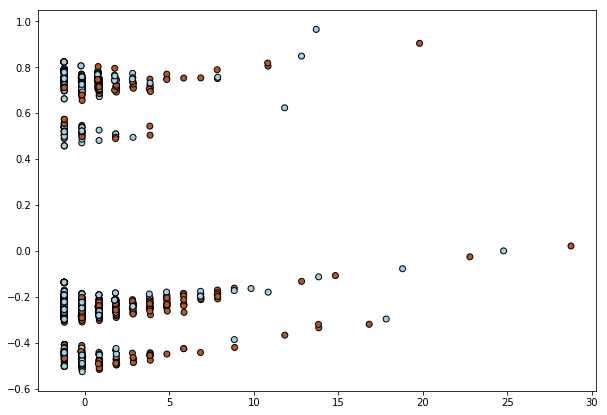

In [87]:
x_2 = deepcopy(x)
pca = PCA(n_components=2, random_state=43, svd_solver='randomized')
x_3 = pca.fit_transform(x_2)

plt.figure(figsize=(10,7))
plt.scatter(x_3[:, 0], x_3[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.show()


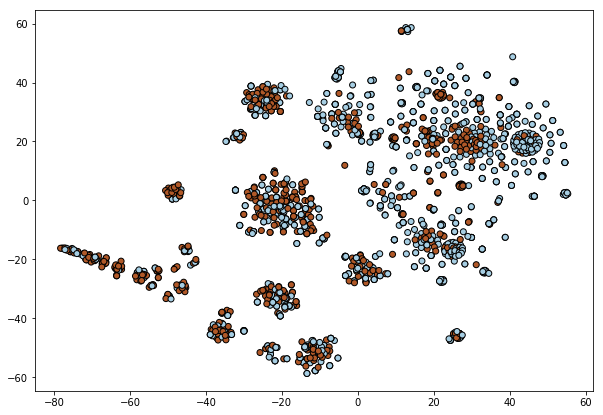

CPU times: user 453 ms, sys: 7.87 ms, total: 461 ms
Wall time: 458 ms


In [86]:
%%time
x_4 = TSNE(n_components=2).fit_transform(x_2)

plt.figure(figsize=(10,7))
plt.scatter(x_4[:, 0], x_4[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.show()